# Quiz 2 Study Notes

In [ ]:
library(tidyverse)

In [ ]:
cancer <- read_csv("data/wdbc.csv") %>%
  mutate(Class = as_factor(Class))
glimpse(cancer)

In [ ]:
# pull function to extract a single column (Class) and pass that into the levels function to see the categories in the Class column.
cancer |>
  pull(Class) |>
  levels()

In [ ]:
# summary of exploring dataset, count of each class
num_obs <- nrow(cancer)
cancer |>
  group_by(Class) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

In [ ]:
new_obs_Perimeter <- 0
new_obs_Concavity <- 3.5
cancer |>
  select(ID, Perimeter, Concavity, Class) |>
  mutate(dist_from_new = sqrt((Perimeter - new_obs_Perimeter)^2 + 
                              (Concavity - new_obs_Concavity)^2)) |>
  arrange(dist_from_new) |>
  slice(1:5) # take the first 5 rows

In [ ]:
perim_concav <- cancer |>
  ggplot(aes(x = Perimeter, y = Concavity, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "Perimeter (standardized)", 
       y = "Concavity (standardized)",
       color = "Diagnosis") +
  scale_color_manual(labels = c("Malignant", "Benign"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
perim_concav

the  K-nearest neighbors classifier generally finds the K “nearest” or “most similar” observations in our training set, and then uses their diagnoses to make a prediction for the new observation’s diagnosis.  


# Distance Calculation
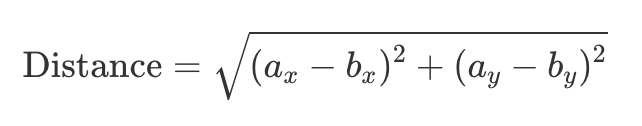

In [ ]:
# mannual distance calculation
new_obs_Perimeter <- 0
new_obs_Concavity <- 3.5
cancer |>
  select(ID, Perimeter, Concavity, Class) |>
  mutate(dist_from_new = sqrt((Perimeter - new_obs_Perimeter)^2 + 
                              (Concavity - new_obs_Concavity)^2)) |>
  arrange(dist_from_new) |>
  slice(1:5) # take the first 5 rows

# More than two explanatory variables
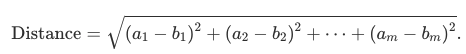

In [ ]:
new_obs_Perimeter <- 0
new_obs_Concavity <- 3.5
new_obs_Symmetry <- 1

cancer |>
  select(ID, Perimeter, Concavity, Symmetry, Class) |>
  mutate(dist_from_new = sqrt((Perimeter - new_obs_Perimeter)^2 + 
                              (Concavity - new_obs_Concavity)^2 +
                                (Symmetry - new_obs_Symmetry)^2)) |>
  arrange(dist_from_new) |>
  slice(1:5) # take the first 5 rows

# Summary of K-nearest neighbors algorithm

In order to classify a new observation using a K-nearest neighbor classifier, we have to do the following:

1. Compute the distance between the new observation and each observation in the training set.
2. Sort the data table in ascending order according to the distances.
3. Choose the top K rows of the sorted table.
4. Classify the new observation based on a majority vote of the neighbor classes.

  
 # K-nearest neighbors with tidymodels

In [ ]:
library(tidymodels)
cancer_train <- cancer |>
  select(Class, Perimeter, Concavity)
cancer_train

In [ ]:
# model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_spec
 
# fitting two vars from training data with the model
knn_fit <- knn_spec |>
  fit(Class ~ Perimeter + Concavity, data = cancer_train)

# pass the model specification and the data set to the fit function
knn_fit <- knn_spec |>
  fit(Class ~ ., data = cancer_train)
knn_fit

# make the prediction on the new observation by calling the predict function
new_obs <- tibble(Perimeter = 0, Concavity = 3.5)
predict(knn_fit, new_obs)

# Centering and scaling

When using K-nearest neighbor classification, the scale of each variable (i.e., its size and range of values) matters. Since the classifier predicts classes by identifying observations nearest to it, any variables with a large scale will have a much larger effect than variables with a small scale. But just because a variable has a large scale doesn’t mean that it is more important for making accurate predictions.

In many other predictive models, the center of each variable (e.g., its mean) matters as well. For example, if we had a data set with a temperature variable measured in degrees Kelvin, and the same data set with temperature measured in degrees Celsius, the two variables would differ by a constant shift of 273 (even though they contain exactly the same information). Likewise, in our hypothetical job classification example, we would likely see that the center of the salary variable is in the tens of thousands, while the center of the years of education variable is in the single digits. Although this doesn’t affect the K-nearest neighbor classification algorithm, this large shift can change the outcome of using many other predictive models.

 For each observed value of the variable, we subtract the mean (i.e., center the variable) and divide by the standard deviation (i.e., scale the variable). When we do this, the data is said to be standardized, and all variables in a data set will have a mean of 0 and a standard deviation of 1.

In [ ]:
unscaled_cancer <- read_csv("data/unscaled_wdbc.csv") |>
  mutate(Class = as_factor(Class)) |>
  select(Class, Area, Smoothness)
unscaled_cancer
uc_recipe <- recipe(Class ~ ., data = unscaled_cancer)
print(uc_recipe)

uc_recipe <- uc_recipe |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  prep() #prep function finalizes the recipe by using the data (here, unscaled_cancer) to compute anything necessary to run the recipe 
# (in this case, the column means and standard deviations)
uc_recipe

# To actually scale and center the data, we need to apply the bake function to the unscaled data.
scaled_cancer <- bake(uc_recipe, unscaled_cancer)
scaled_cancer

# note that using prep and bake is required only when you want to inspect the result of the preprocessing steps yourself.

In [ ]:
# upsampling for balance
library(themis)

ups_recipe <- recipe(Class ~ ., data = rare_cancer) |>
  step_upsample(Class, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

upsampled_cancer <- bake(ups_recipe, rare_cancer)

upsampled_cancer |>
  group_by(Class) |>
  summarize(n = n())

# Workflow

In [ ]:
# load the unscaled cancer data 
# and make sure the target Class variable is a factor
unscaled_cancer <- read_csv("data/unscaled_wdbc.csv") |>
  mutate(Class = as_factor(Class))

# create the KNN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

# create the centering / scaling recipe
uc_recipe <- recipe(Class ~ Area + Smoothness, data = unscaled_cancer) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(uc_recipe) |>
  add_model(knn_spec) |>
  fit(data = unscaled_cancer)

knn_fit



# prediction
new_observation <- tibble(Area = c(500, 1500), Smoothness = c(0.075, 0.1))
prediction <- predict(knn_fit, new_observation)

prediction



# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(unscaled_cancer$Area), 
                max(unscaled_cancer$Area), 
                length.out = 100)
smo_grid <- seq(min(unscaled_cancer$Smoothness), 
                max(unscaled_cancer$Smoothness), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(Area = are_grid, 
                                Smoothness = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)

# Chapter 6 Classification II: evaluation & tuning

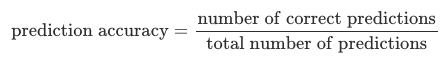
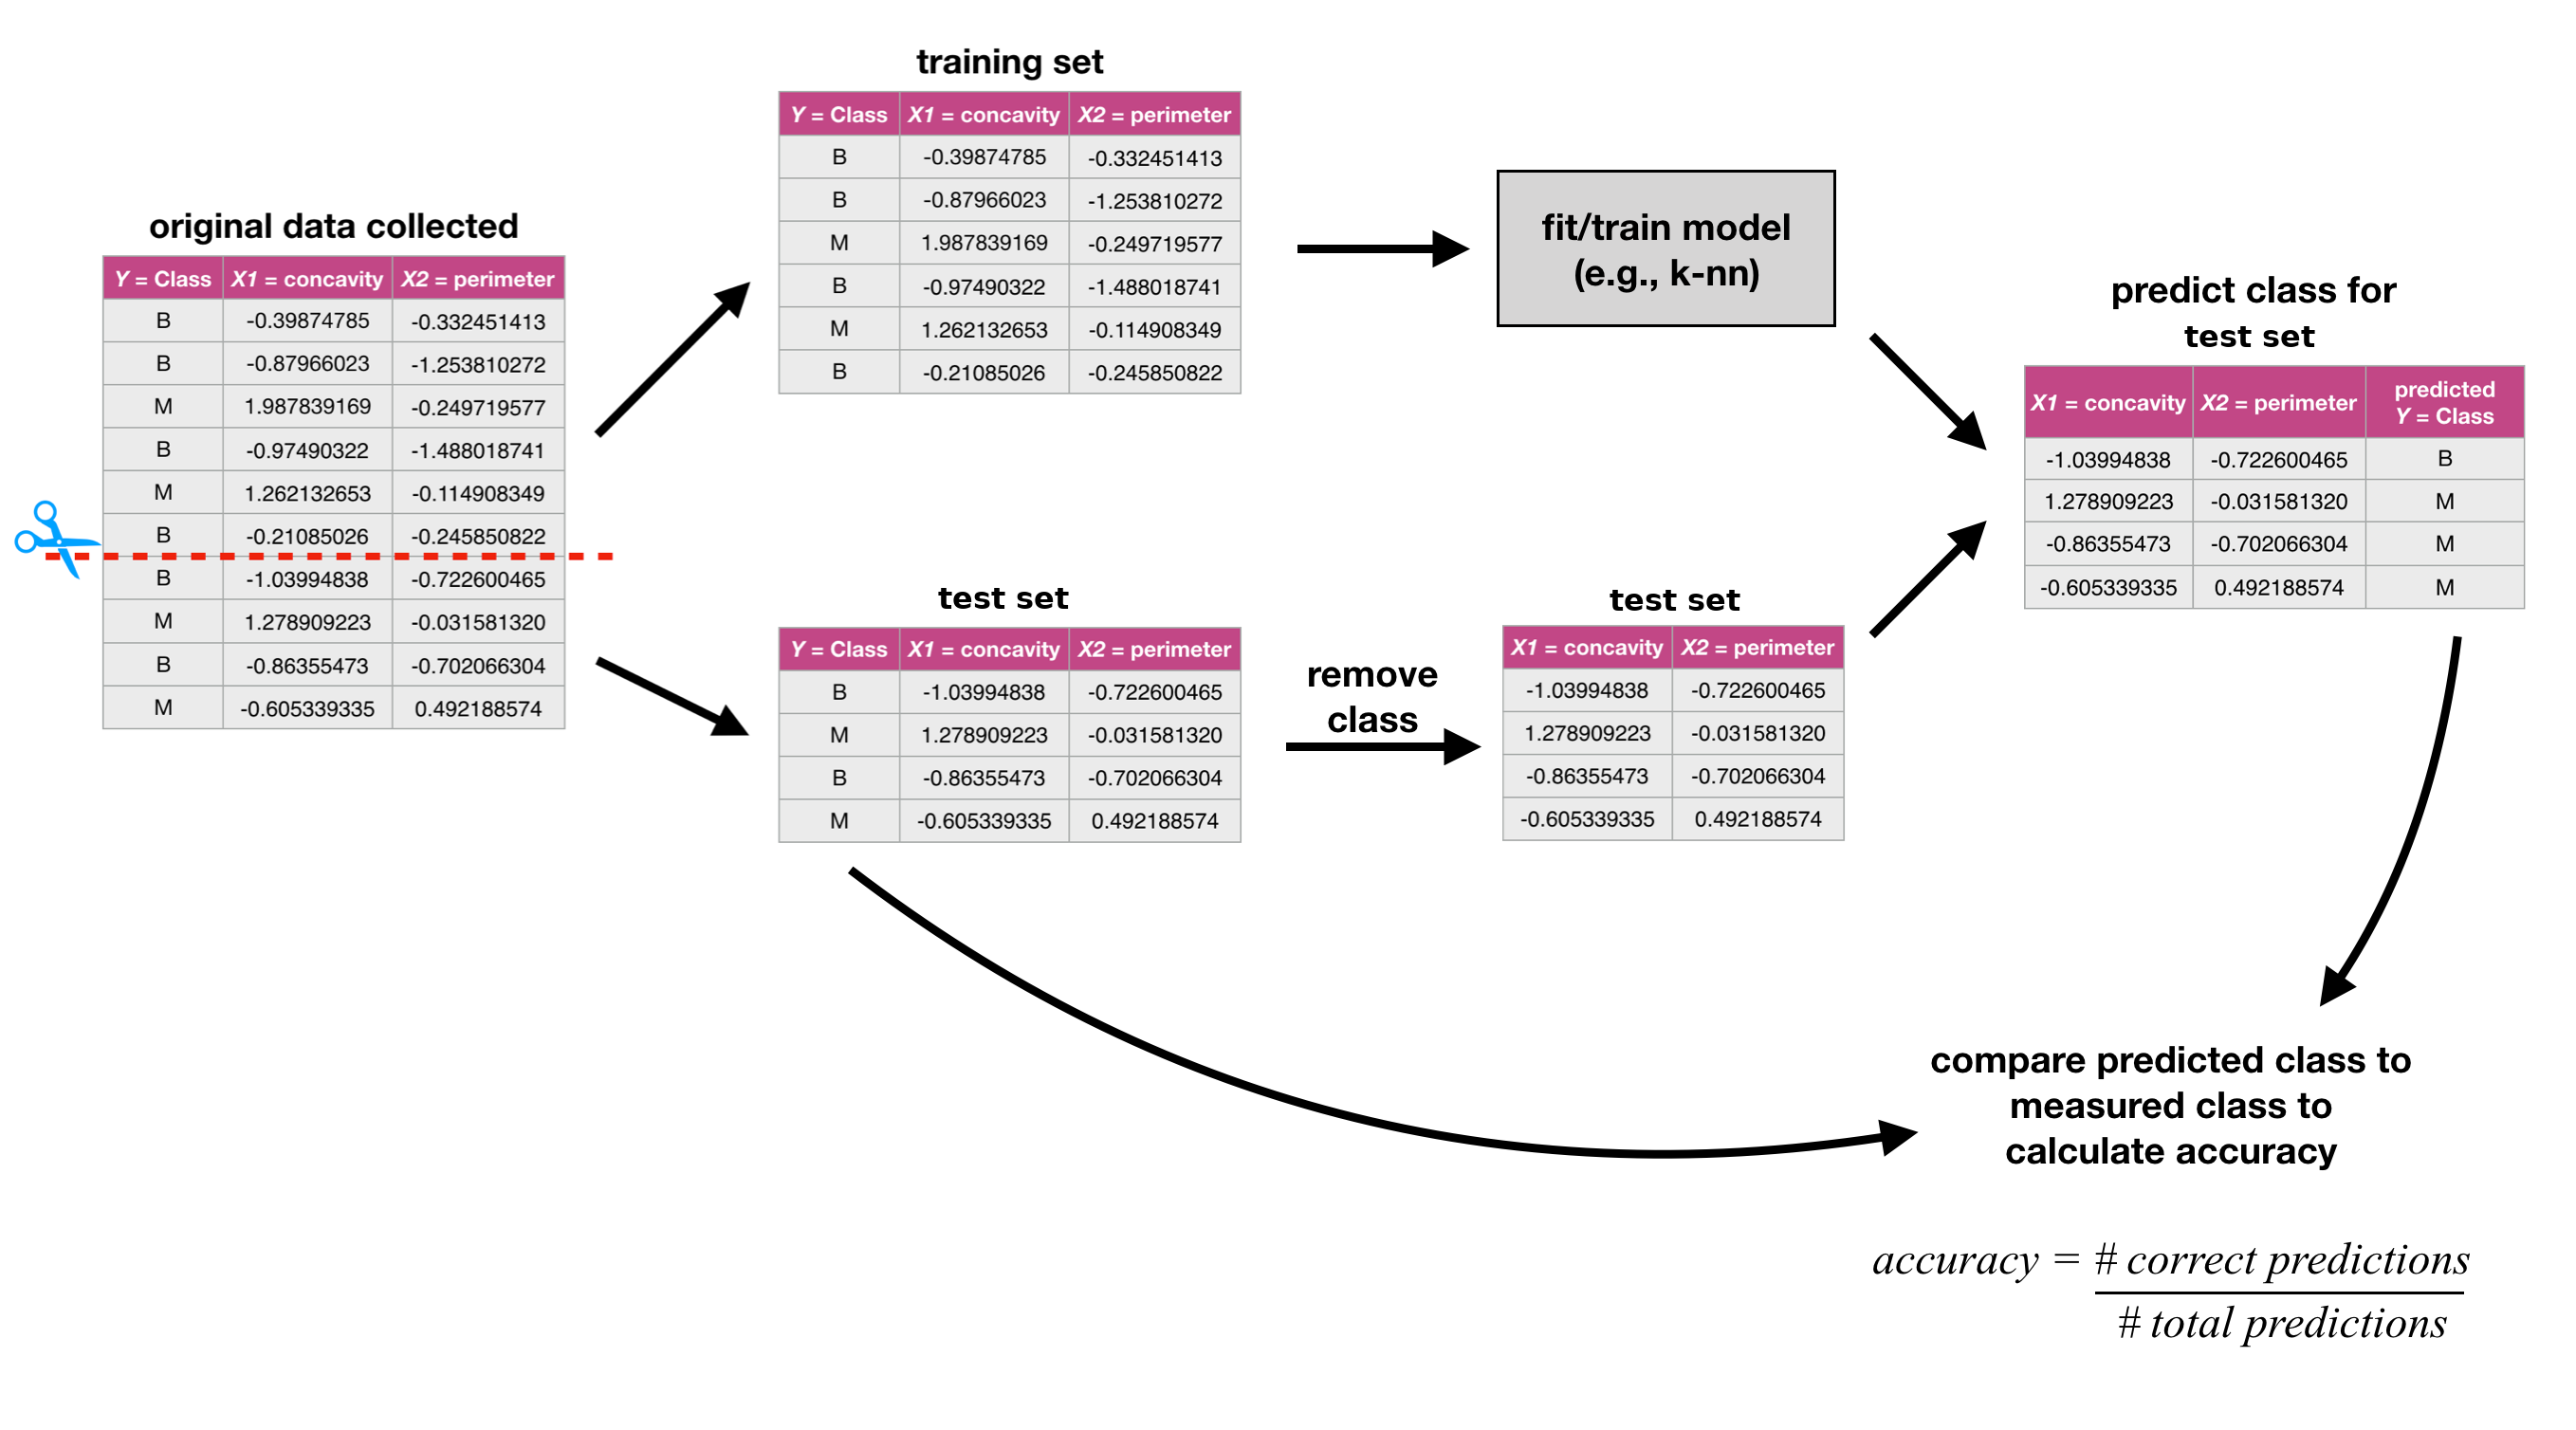

# Randomness and seeds

Once you set the seed value using the set.seed function, everything after that point may look random, but is actually totally reproducible. As long as you pick the same seed value, you get the same result!

be careful to set the seed only once at the beginning of a data analysis. Each time you set the seed, you are inserting your own human input, thereby influencing the analysis. If you use set.seed many times throughout your analysis, the randomness that R uses will not look as random as it should.

In [ ]:
set.seed(4235)
random_numbers <- sample(0:9, 10, replace=TRUE)
random_numbers

In [ ]:
# load packages
library(tidyverse)
library(tidymodels)

# set the seed
set.seed(1)

# load data
cancer <- read_csv("data/unscaled_wdbc.csv") |>
  # convert the character Class variable to the factor datatype
  mutate(Class = as_factor(Class)) 

# create scatter plot of tumor cell concavity versus smoothness,
# labeling the points be diagnosis class
perim_concav <- cancer |>
  ggplot(aes(x = Smoothness, y = Concavity, color = Class)) +
  geom_point(alpha = 0.5) +
  labs(color = "Diagnosis") +
  scale_color_manual(labels = c("Malignant", "Benign"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))

perim_concav

# Splitting Testing and Training set

 First, it shuffles the data before splitting, which ensures that any ordering present in the data does not influence the data that ends up in the training and testing sets. 
 
 Second, it stratifies the data by the class label, to ensure that roughly the same proportion of each class ends up in both the training and testing sets.

In [ ]:
cancer_split <- initial_split(cancer, prop = 0.75, strata = Class)
cancer_train <- training(cancer_split)
cancer_test <- testing(cancer_split) 

# to find if proportions were retained by the split
cancer_proportions <- cancer_train |>
                      group_by(Class) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(cancer_train))

cancer_proportions

In [ ]:
# preprocess the data (center and scale) -- TRAINING DATA ONLY
cancer_recipe <- recipe(Class ~ Smoothness + Concavity, data = cancer_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

In [ ]:
# Training the classfier - fit on TRAINING SET

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(cancer_recipe) |>
  add_model(knn_spec) |>
  fit(data = cancer_train)

knn_fit

In [ ]:
# Predictions - run on TESTING SET and bind with TESTING SET
cancer_test_predictions <- predict(knn_fit, cancer_test) |>
  bind_cols(cancer_test)

cancer_test_predictions

In [ ]:
# Compute Accuracy
cancer_test_predictions |>
  metrics(truth = Class, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# generate confusion matrix (TT, TF, FT, FF)
confusion <- cancer_test_predictions |>
             conf_mat(truth = Class, estimate = .pred_class)

confusion

# Tuning the classifier
 Cross-validation
 
 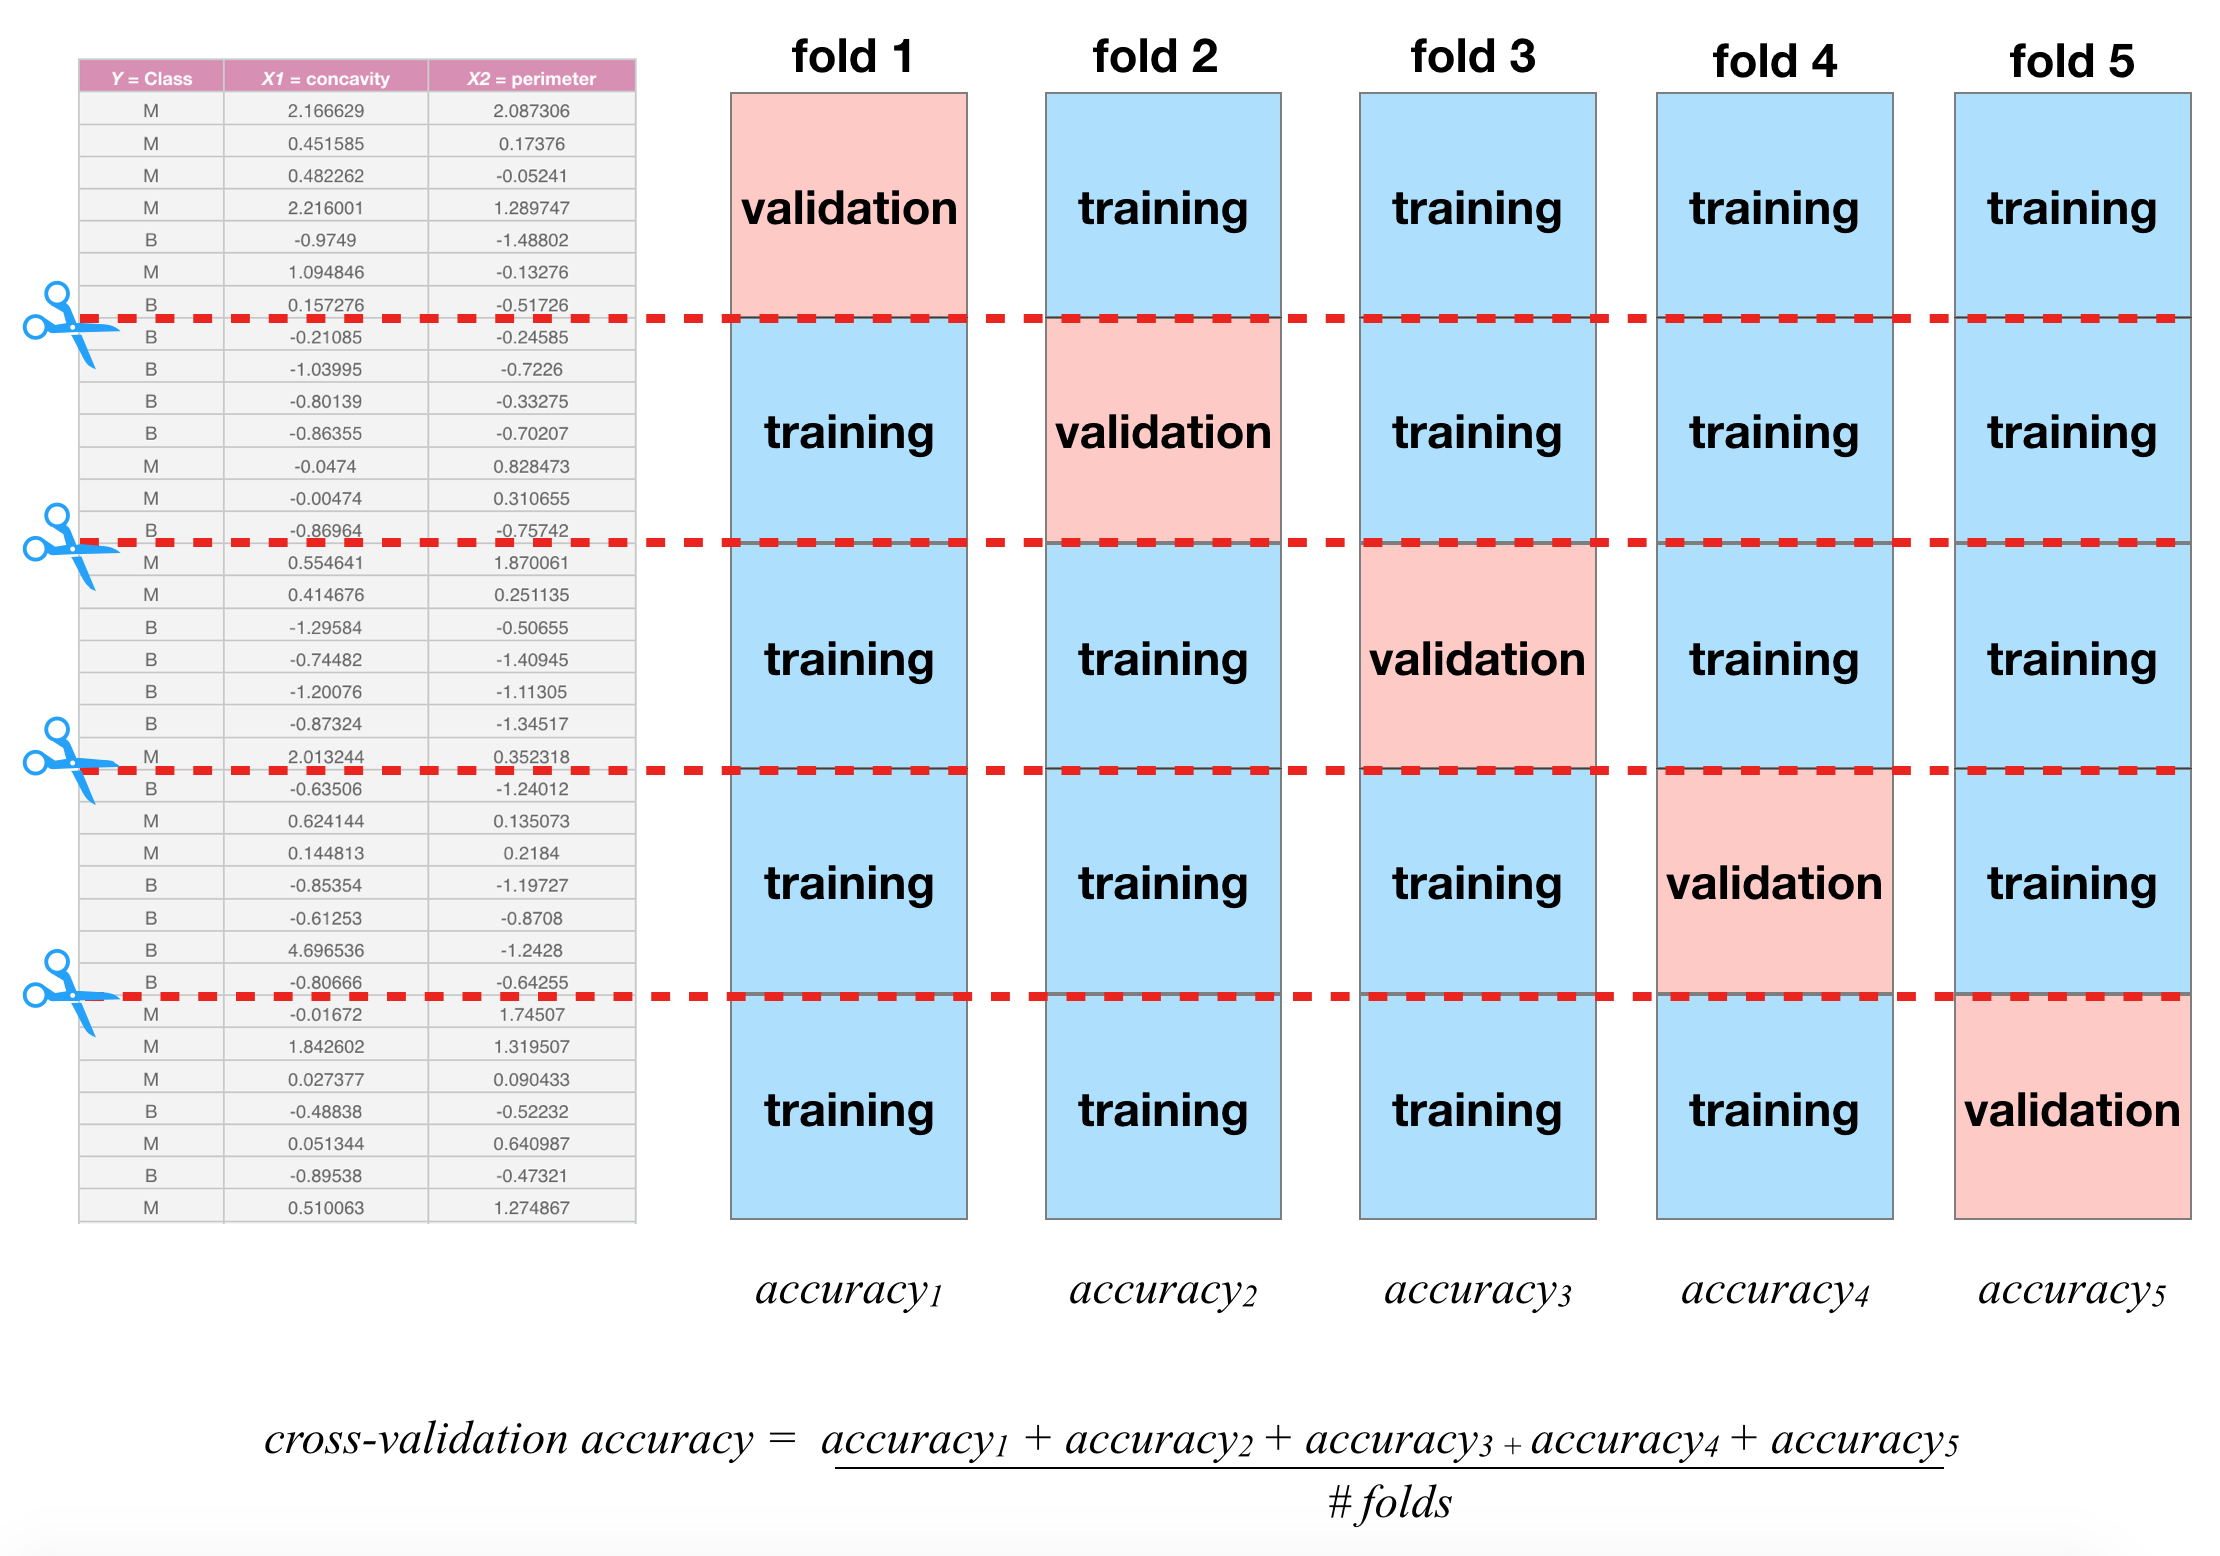

In [ ]:
# Doing cross validation mannually --> need to do this 4 times

# create the 25/75 split of the training data into training and validation
cancer_split <- initial_split(cancer_train, prop = 0.75, strata = Class)
cancer_subtrain <- training(cancer_split)
cancer_validation <- testing(cancer_split)

# recreate the standardization recipe from before 
# (since it must be based on the training data)
cancer_recipe <- recipe(Class ~ Smoothness + Concavity, 
                        data = cancer_subtrain) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model (we can reuse the old knn_spec model from before)
knn_fit <- workflow() |>
  add_recipe(cancer_recipe) |>
  add_model(knn_spec) |>
  fit(data = cancer_subtrain)

# get predictions on the validation data
validation_predicted <- predict(knn_fit, cancer_validation) |>
  bind_cols(cancer_validation)

# compute the accuracy
acc <- validation_predicted |>
  metrics(truth = Class, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()

acc

In [ ]:
# using vfold_cv()
cancer_vfold <- vfold_cv(cancer_train, v = 5, strata = Class)
cancer_vfold

# recreate the standardization recipe from before 
# (since it must be based on the training data)
cancer_recipe <- recipe(Class ~ Smoothness + Concavity, 
                        data = cancer_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model (we can reuse the old knn_spec model from before)
knn_fit <- workflow() |>
  add_recipe(cancer_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = cancer_vfold) # This runs cross-validation on each train/validation split.

knn_fit

# aggregate the mean and standard error of the classifier’s validation accuracy across the folds
knn_fit |> 
  collect_metrics() 

In [ ]:
# 10 fold cross validation
cancer_vfold <- vfold_cv(cancer_train, v = 10, strata = Class)

vfold_metrics <- workflow() |>
                  add_recipe(cancer_recipe) |>
                  add_model(knn_spec) |>
                  fit_resamples(resamples = cancer_vfold) |>
                  collect_metrics()

vfold_metrics

# Parameter value selection

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |> # with tune()
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(cancer_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cancer_vfold, grid = k_vals) |> # tune_grid - fit the model for each value in a range of parameter values
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

In [ ]:
# plotting accuracies against k values
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

# OverFitting vs. UnderFitting

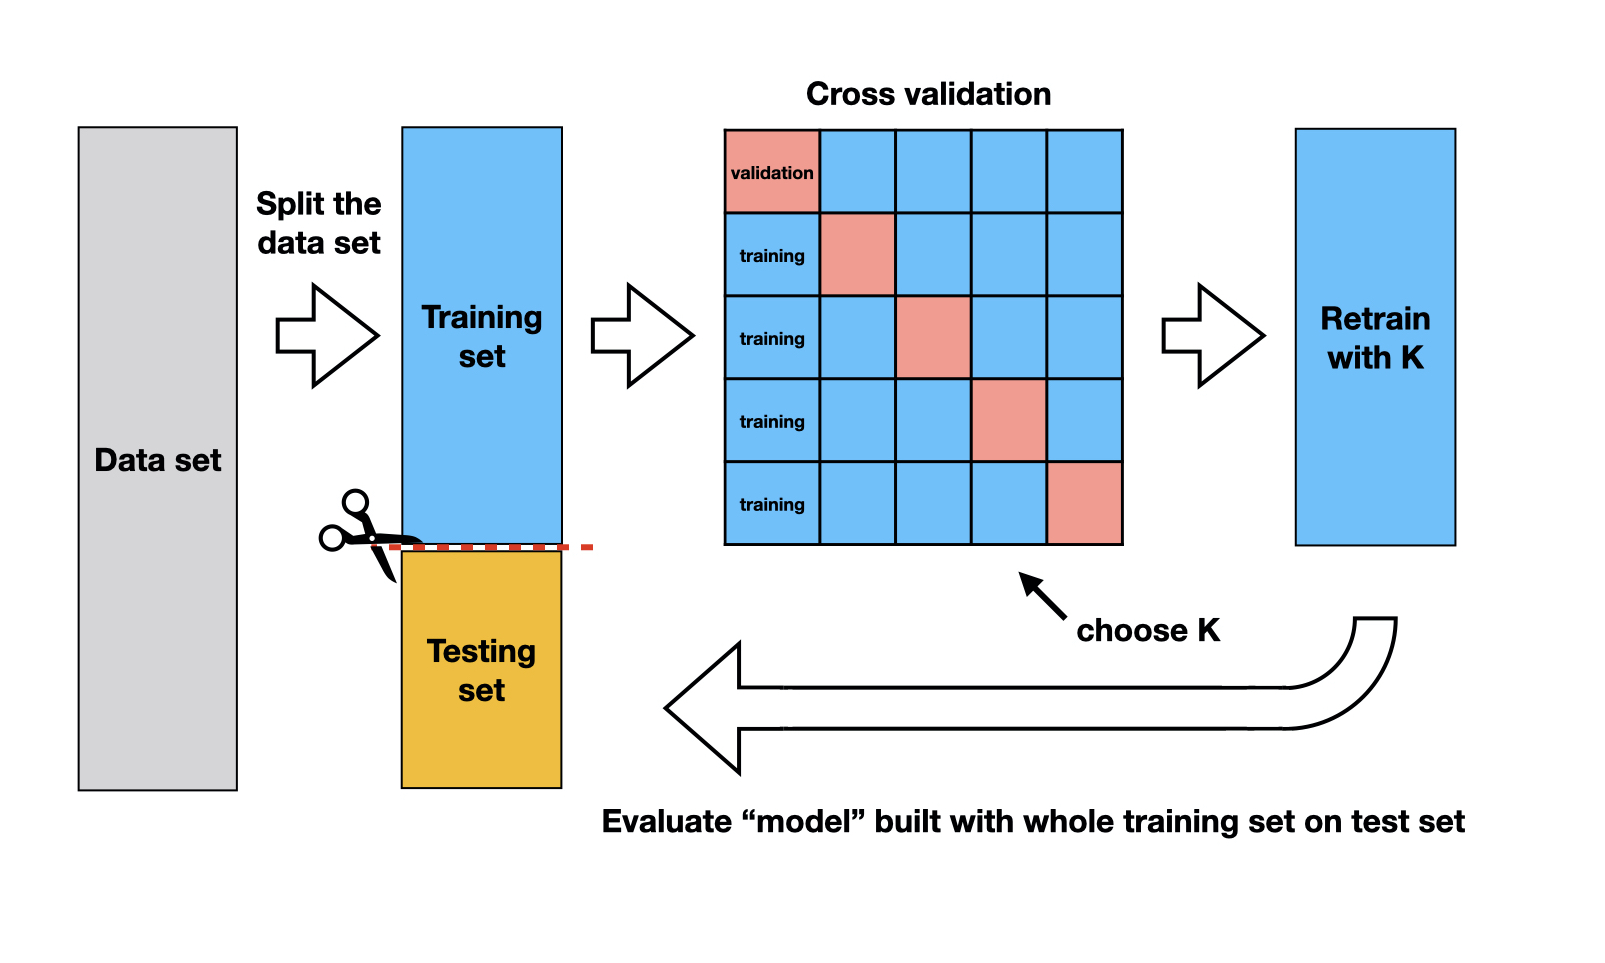

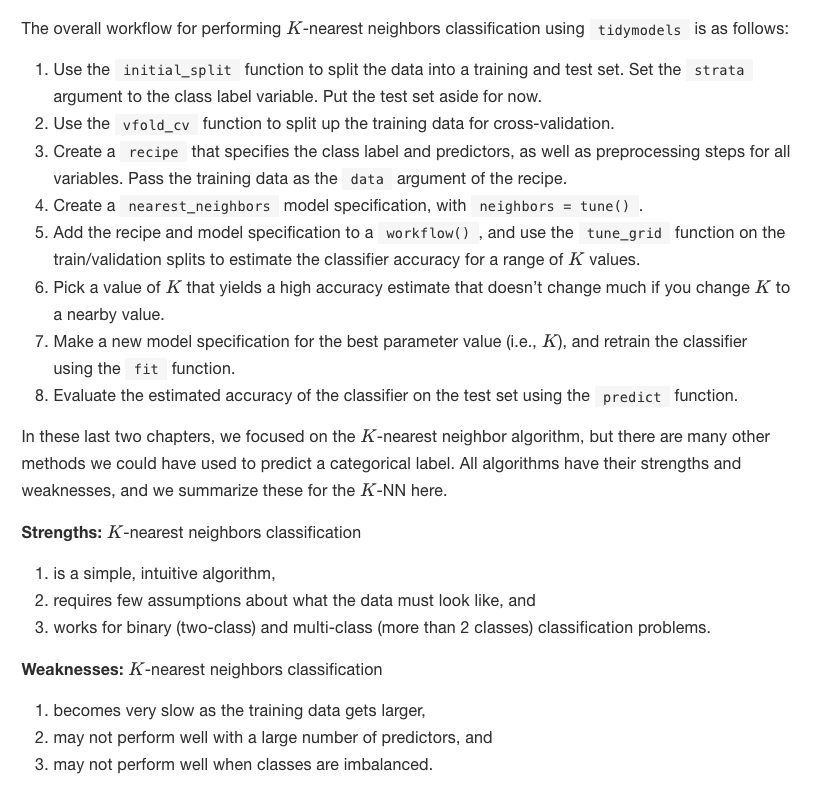

# Chapter 7 Regression I: K-nearest neighbors
Regression, like classification, is a predictive problem setting where we want to use past information to predict future observations. But in the case of regression, the goal is to predict numerical values instead of categorical values. 

In [ ]:
# random sample of 30
small_sacramento <- slice_sample(sacramento, n = 30)

# plot with vline at 2000
small_plot <- ggplot(small_sacramento, aes(x = sqft, y = price)) +
  geom_point() +
  xlab("House size (square feet)") +
  ylab("Price (USD)") +
  scale_y_continuous(labels = dollar_format()) +
  geom_vline(xintercept = 2000, linetype = "dotted") + 
  theme(text = element_text(size = 12))

small_plot

# mannual calculation of difference
nearest_neighbors <- small_sacramento |>
  mutate(diff = abs(2000 - sqft)) |>
  arrange(diff) |>
  slice(1:5) #subset the first 5 rows

nearest_neighbors
 
# averaging the distances
prediction <- nearest_neighbors |>
  summarise(predicted = mean(price))

prediction

# Training, evaluating, and tuning the model

In [ ]:
sacramento_split <- initial_split(sacramento, prop = 0.75, strata = price)
sacramento_train <- training(sacramento_split)
sacramento_test <- testing(sacramento_split)

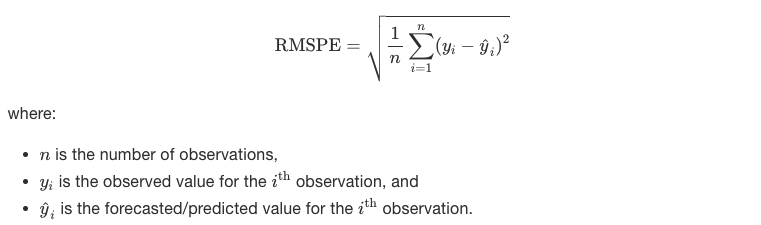

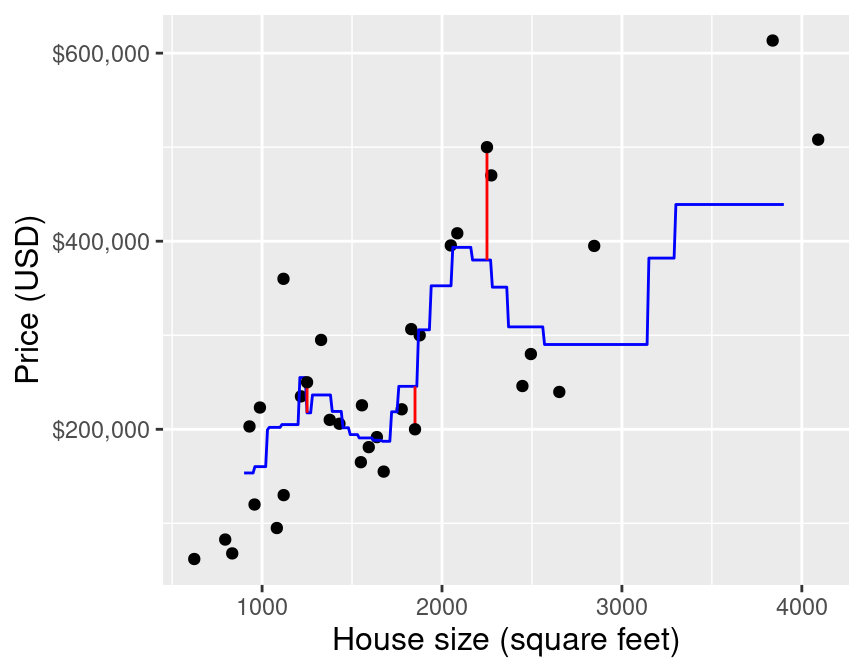

In [ ]:
# set up recipe and workflow
sacr_recipe <- recipe(price ~ sqft, data = sacramento_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

sacr_spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

sacr_vfold <- vfold_cv(sacramento_train, v = 5, strata = price)

sacr_wkflw <- workflow() |>
  add_recipe(sacr_recipe) |>
  add_model(sacr_spec)

sacr_wkflw

# tuning for k 
gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 3))

sacr_results <- sacr_wkflw |>
  tune_grid(resamples = sacr_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

# show the results
sacr_results

# show only the row of minimum RMSPE
sacr_min <- sacr_results |>
  filter(mean == min(mean))

sacr_min

In [ ]:
# Evaluating on the testing set
kmin <- sacr_min |> pull(neighbors)

sacr_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

sacr_fit <- workflow() |>
  add_recipe(sacr_recipe) |>
  add_model(sacr_spec) |>
  fit(data = sacramento_train)

sacr_summary <- sacr_fit |>
  predict(sacramento_test) |>
  bind_cols(sacramento_test) |>
  metrics(truth = price, estimate = .pred) |>
  filter(.metric == 'rmse')

sacr_summary


sacr_preds <- tibble(sqft = seq(from = 500, to = 5000, by = 10))

sacr_preds <- sacr_fit |>
  predict(sacr_preds) |>
  bind_cols(sacr_preds)

plot_final <- ggplot(sacramento_train, aes(x = sqft, y = price)) +
  geom_point(alpha = 0.4) +
  geom_line(data = sacr_preds, 
            mapping = aes(x = sqft, y = .pred), 
            color = "blue") +
  xlab("House size (square feet)") +
  ylab("Price (USD)") +
  scale_y_continuous(labels = dollar_format()) +
  ggtitle(paste0("K = ", kmin)) + 
  theme(text = element_text(size = 12))

plot_final

### Multivariable KNN regression
check textbook 7.9

# Strengths and limitations of KNN regression

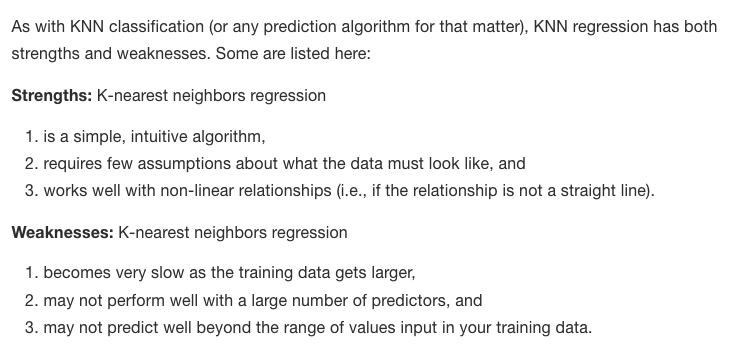